**Plant Disease Detection**

**Machine Learning model using Tensorflow with Keras**

We designed algorithms and models to recognize species and diseases in the crop leaves by using Convolutional Neural Network

**Importing the Librairies**

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import VGG16,VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout
import os
from zipfile import ZipFile
from urllib.request import urlretrieve
import time
from os.path import exists
from PIL import Image
import json
import matplotlib.pylab as plt
import numpy as np

# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load the data**

We will download a public dataset of 54,305 images of diseased and healthy plant leaves collected under controlled conditions ( PlantVillage Dataset). The images cover 14 species of crops, including: apple, blueberry, cherry, grape, orange, peach, pepper, potato, raspberry, soy, squash, strawberry and tomato. It contains images of 17 basic diseases, 4 bacterial diseases, 2 diseases caused by mold (oomycete), 2 viral diseases and 1 disease caused by a mite. 12 crop species also have healthy leaf images that are not visibly affected by disease. Then store the downloaded zip file to the "/tmp/" directory.

we'll need to make sure the input data is resized to 224x224 or 229x229 pixels as required by the networks.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mdminhajhossain430","key":"ab7a22773a32a5f7073a20c8ac35d458"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mohitsingh1804/plantvillage

Dataset URL: https://www.kaggle.com/datasets/mohitsingh1804/plantvillage
License(s): GPL-2.0
100% 817M/818M [00:21<00:00, 41.1MB/s]
100% 818M/818M [00:21<00:00, 40.2MB/s]


In [ ]:
!unzip {'plantvillage.zip'}

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/val/Soybean___healthy/52c7d07b-561b-4380-801a-3824e65a5135___RS_HL 3797.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53168d1c-ac90-4039-9eff-7479475a6b74___RS_HL 6355.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5344b09f-bbbe-4a2c-9345-d93dd4e69eb4___RS_HL 4693.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5361ba4a-351e-466c-99c5-8845f35c00df___RS_HL 2890.JPG  
  inflating: PlantVillage/val/Soybean___healthy/537e5409-d824-4859-967f-3c502f13deec___RS_HL 5474.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538969da-545b-4bce-bc1d-0932898dc5e6___RS_HL 5230.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538ccfe2-1509-40d7-beae-ae7cf84e1e5d___RS_HL 3717.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5397bf6a-aeeb-4f1c-b554-bdb604bb23c3___RS_HL 6508.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53dc0466-621c-43e1-9c5e-e340f3d50171___RS_HL 6381.JPG  
  inflating: 

**Prepare training and validation dataset**

Create the training and validation directories

In [ ]:
data_dir = os.path.join(os.getcwd(), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')

In [ ]:
def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

total images for training : /content/PlantVillage/train : 43444files
total images for validation : /content/PlantVillage/val : 10861files


Cherry_(including_sour)___Powdery_mildew


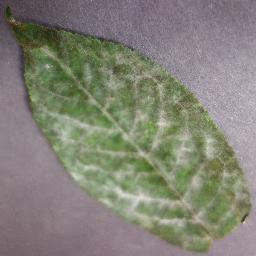

Corn_(maize)___healthy


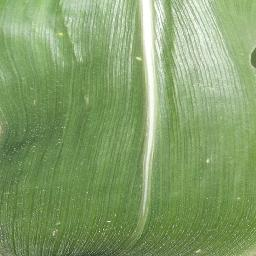

Potato___Early_blight


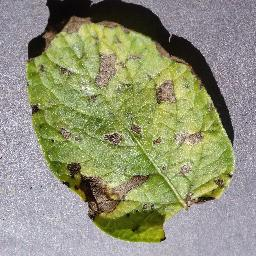

Potato___healthy


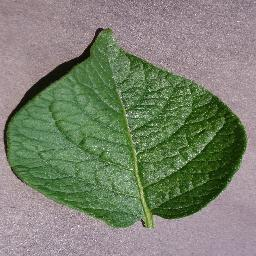

Strawberry___Leaf_scorch


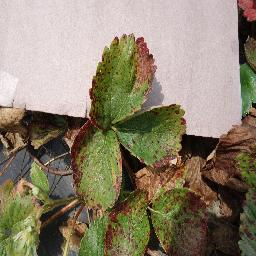

Tomato___Target_Spot


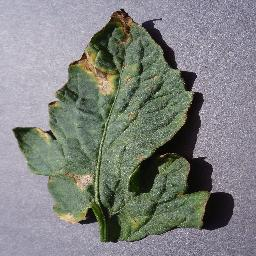

Potato___Late_blight


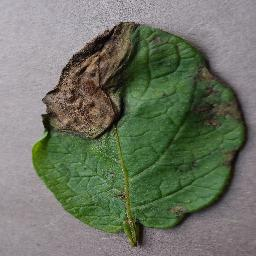

Pepper,_bell___Bacterial_spot


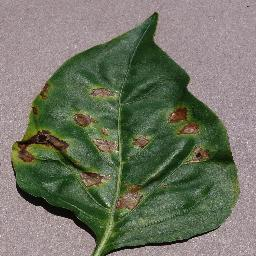

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


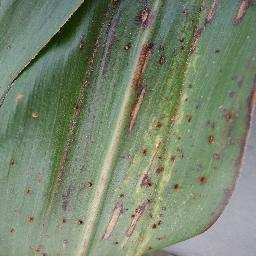

Grape___Esca_(Black_Measles)


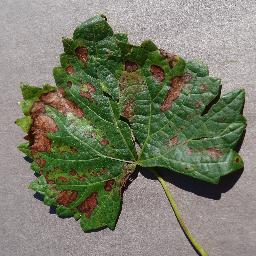

Grape___Leaf_blight_(Isariopsis_Leaf_Spot)


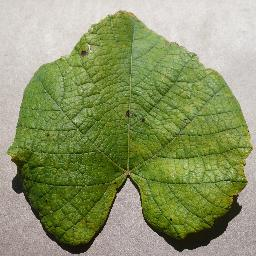

Apple___Black_rot


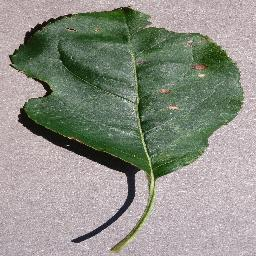

Peach___Bacterial_spot


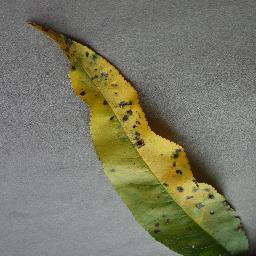

Tomato___healthy


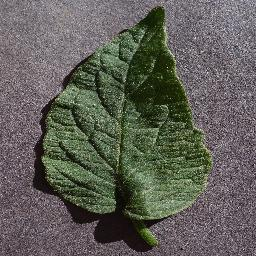

Squash___Powdery_mildew


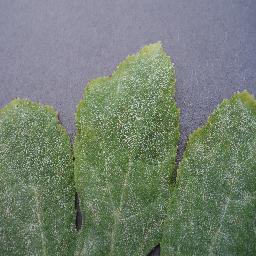

Tomato___Septoria_leaf_spot


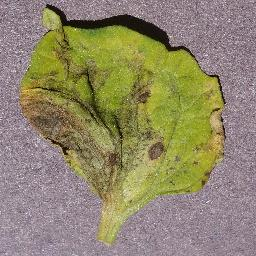

Tomato___Bacterial_spot


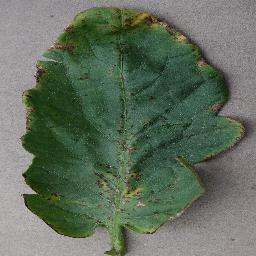

Pepper,_bell___healthy


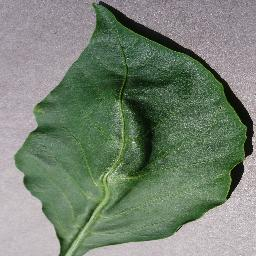

Orange___Haunglongbing_(Citrus_greening)


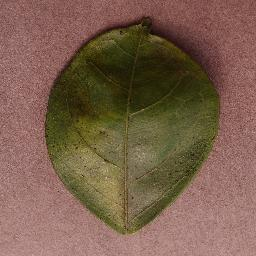

Grape___Black_rot


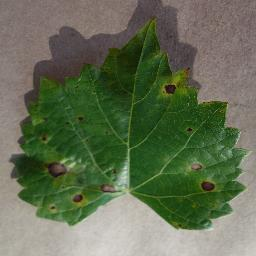

Raspberry___healthy


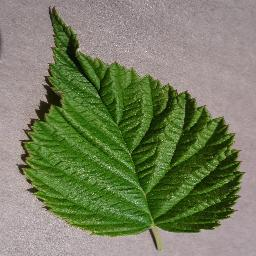

Peach___healthy


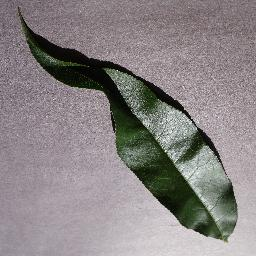

Grape___healthy


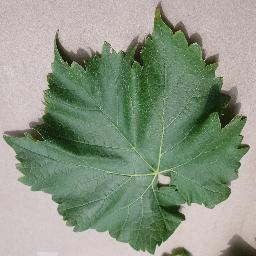

Tomato___Tomato_mosaic_virus


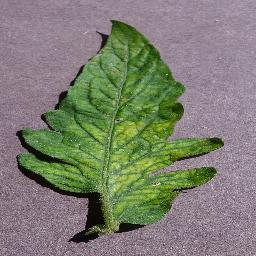

Tomato___Tomato_Yellow_Leaf_Curl_Virus


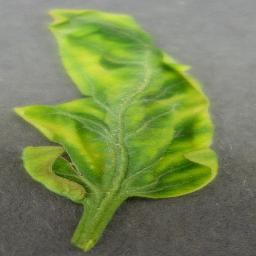

Soybean___healthy


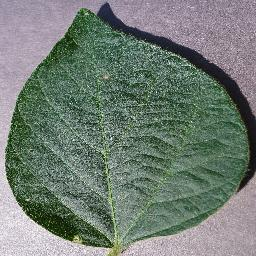

Blueberry___healthy


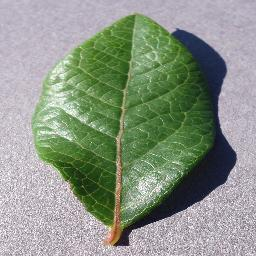

Tomato___Leaf_Mold


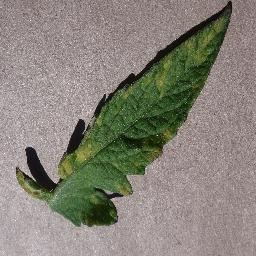

Tomato___Late_blight


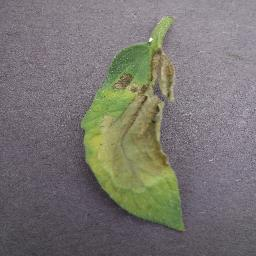

Apple___Cedar_apple_rust


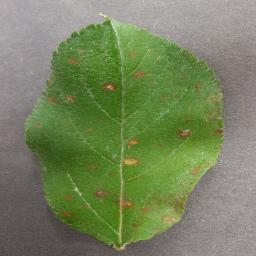

Apple___healthy


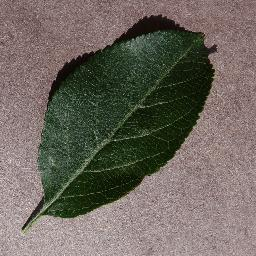

Cherry_(including_sour)___healthy


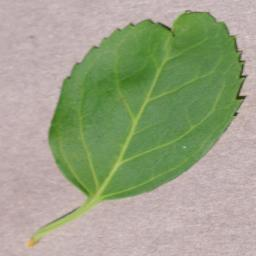

Corn_(maize)___Common_rust_


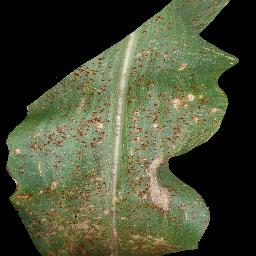

Corn_(maize)___Northern_Leaf_Blight


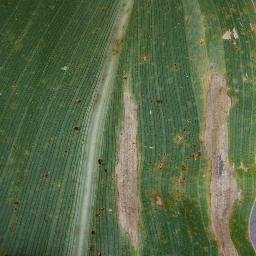

Apple___Apple_scab


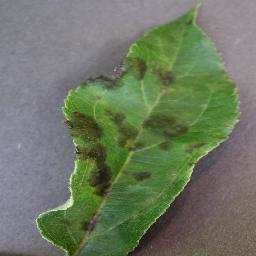

Tomato___Early_blight


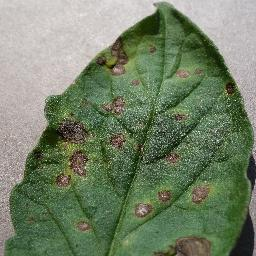

Strawberry___healthy


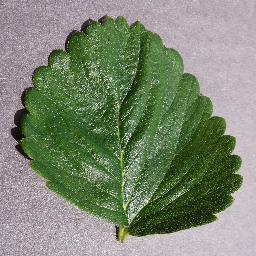

Tomato___Spider_mites Two-spotted_spider_mite


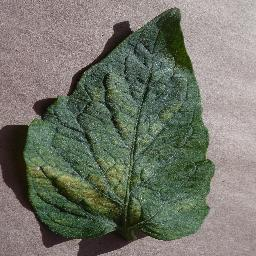

In [ ]:
# Get a list of subfolder names
subfolder_names = [f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))]

# Iterate through each subfolder
for folder_name in subfolder_names:
  folder_path = os.path.join(train_dir, folder_name)

  # Display the folder name
  print(folder_name)

  # Display the first image in the folder
  image_list = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
  first_image_path = os.path.join(folder_path, image_list[0])
  image = Image.open(first_image_path)
  display(image)

**Label mapping**

You'll also need to load in a mapping from category label to category name. You can find this in the file categories.json. It's a JSON object which you can read in with the json module. This will give you a dictionary mapping the integer encoded categories to the actual names of the plants and diseases.

In [ ]:
categories_file_path = "/content/drive/MyDrive/saved models/categories.json"

In [ ]:
with open(categories_file_path, 'r') as file:
   # file_content = file.read()
#with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
    cat_to_name = json.load(file)
    classes = list(cat_to_name.values())

print('Number of classes:',len(classes))
print (classes)

Number of classes: 38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite

**Setup Image shape and batch size**

In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)", "(\"VGG16\", 224, 4096)", "(\"VGG19\", 224, 4096)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 64 #@param {type:"integer"}

**Data Preprocessing**

In [ ]:
# Inputs are suitably resized for the selected module.
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 10861 images belonging to 38 classes.
Found 43444 images belonging to 38 classes.


**Build the model**

All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [ ]:
if (handle_base == 'mobilenet_v2' or handle_base == 'inception_v3'):
  MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
  feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   output_shape=[FV_SIZE])
  do_fine_tuning = False  # @param {type:"boolean"}
  if do_fine_tuning:
      feature_extractor.trainable = True
      # unfreeze some layers of the base network for fine-tuning
      for layer in feature_extractor.layers[-30:]:
          layer.trainable = True
  else:
      feature_extractor.trainable = False

  model = tf.keras.Sequential([
    feature_extractor,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.2),
    Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

if (handle_base == 'VGG16' or handle_base == 'VGG19'):
  if (handle_base == 'VGG16'):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(pixels, pixels, 3))
    base_model.trainable = False


  if (handle_base == 'VGG19'):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(pixels, pixels, 3))
    base_model.trainable = False


  # Build model
  model = tf.keras.Sequential([
      base_model,
      Flatten(),
      Dense(512, activation='relu'),
      Dropout(rate=0.2),
      Dense(train_generator.num_classes, activation='softmax',
            kernel_regularizer=tf.keras.regularizers.l2(0.0001))
  ])



**Specify Loss Function and Optimizer**

In [ ]:
#Compile model specifying the optimizer learning rate
LEARNING_RATE = 0.001 #@param {type:"number"}
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
   loss='categorical_crossentropy',
   metrics=['accuracy'])

**Train Model**

**train model using validation dataset for validate each steps**

In [ ]:
import csv
import tensorflow.keras.backend as K
from tensorflow import keras
import os

model_directory='/content/drive/MyDrive/saved models/' # directory to save model history after every epoch
class StoreModelHistory(keras.callbacks.Callback):

  def on_epoch_end(self,batch,logs=None):
    if ('lr' not in logs.keys()):
      logs.setdefault('lr',0)
      logs['lr'] = K.get_value(self.model.optimizer.lr)

    if not (handle_base+'model_history.csv' in os.listdir(model_directory)):
      with open(model_directory+handle_base+'model_history.csv','a') as f:
        y=csv.DictWriter(f,logs.keys())
        y.writeheader()

    with open(model_directory+handle_base+'model_history.csv','a') as f:
      y=csv.DictWriter(f,logs.keys())
      y.writerow(logs)


EPOCHS=10 #@param {type:"integer"}
STEPS_EPOCHS = train_generator.samples//train_generator.batch_size
VALID_STEPS=validation_generator.samples//validation_generator.batch_size
history = model.fit(
          train_generator,
          steps_per_epoch=400,
          epochs=EPOCHS,
          validation_data=validation_generator,
          validation_steps=VALID_STEPS,
          callbacks=[StoreModelHistory()])


model.save(model_directory+handle_base)

**Load Model & History**

In [ ]:
import pandas as pd
from tensorflow.keras.models import load_model

model_directory='/content/drive/MyDrive/saved models/' # directory to save model history after every epoch

history = pd.read_csv(model_directory+handle_base+'model_history.csv',sep=',')
model = load_model("/content/drive/MyDrive/saved models/"+handle_base)

print(history)

       loss  accuracy  val_loss  val_accuracy     lr
0  0.661800  0.810078  0.326968      0.896912  0.001
1  0.336229  0.895420  0.264837      0.916975  0.001
2  0.282572  0.910622  0.235898      0.923447  0.001
3  0.256588  0.918321  0.238631      0.921783  0.001
4  0.238073  0.923519  0.219951      0.929179  0.001
5  0.228185  0.926484  0.196231      0.937592  0.001
6  0.221165  0.928125  0.217811      0.928162  0.001
7  0.207908  0.932625  0.222911      0.928070  0.001
8  0.207296  0.932625  0.200844      0.934449  0.001
9  0.204188  0.933164  0.174538      0.944989  0.001



**Check Performance**

Plot training and validation accuracy and loss

**Random test**

Random sample images from validation dataset and predict

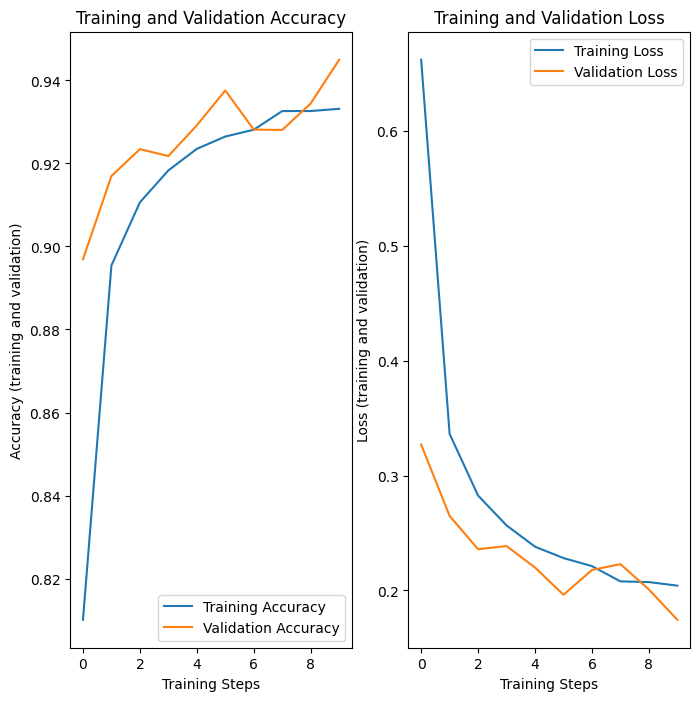

In [ ]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs_range = range(10)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:
def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255

    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)

    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, file: Tomato___Tomato_Yellow_Leaf_Curl_Virus/5ce9b685-28f5-476e-b94e-a1eebdfbe7c6___YLCV_GCREC 2687.JPG
1/1 [==============================] - 1s 1s/step
PREDICTED: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.999989


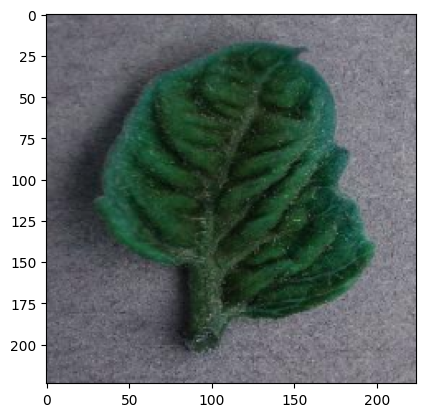

<Figure size 640x480 with 0 Axes>

SOURCE: class: Corn_(maize)___healthy, file: Corn_(maize)___healthy/6c6400e5-cbd1-496f-afae-e8e448ee5a39___R.S_HL 8028 copy 2.jpg
1/1 [==============================] - 0s 91ms/step
PREDICTED: class: Corn_(maize)___healthy, confidence: 0.997572


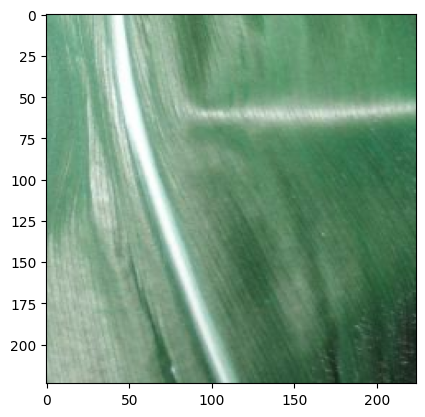

SOURCE: class: Orange___Haunglongbing_(Citrus_greening), file: Orange___Haunglongbing_(Citrus_greening)/d069fafc-155c-4751-834e-2da8d8c08d25___UF.Citrus_HLB_Lab 1532.JPG
1/1 [==============================] - 0s 80ms/step
PREDICTED: class: Orange___Haunglongbing_(Citrus_greening), confidence: 1.000000


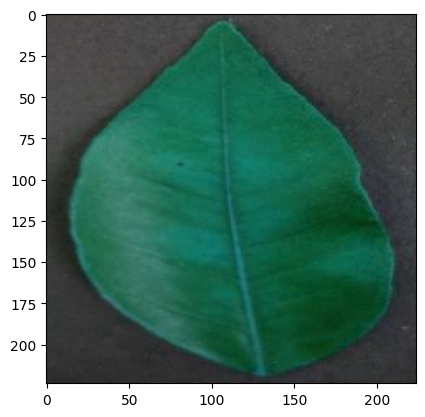

<Figure size 640x480 with 0 Axes>

SOURCE: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, file: Tomato___Tomato_Yellow_Leaf_Curl_Virus/26085f4a-99f0-4c47-944b-5bfef02628b2___UF.GRC_YLCV_Lab 02937.JPG
1/1 [==============================] - 0s 85ms/step
PREDICTED: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, confidence: 0.993605


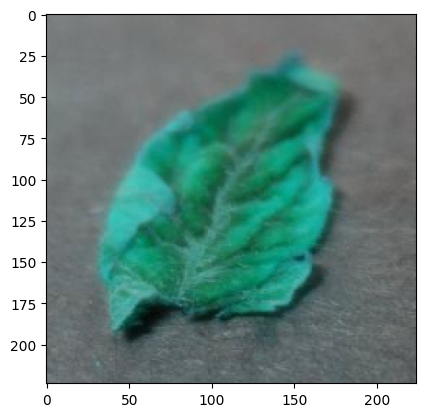

<Figure size 640x480 with 0 Axes>

SOURCE: class: Soybean___healthy, file: Soybean___healthy/d31382d1-76f3-461d-946d-6403bbedc827___RS_HL 3123.JPG
1/1 [==============================] - 0s 87ms/step
PREDICTED: class: Soybean___healthy, confidence: 0.998400


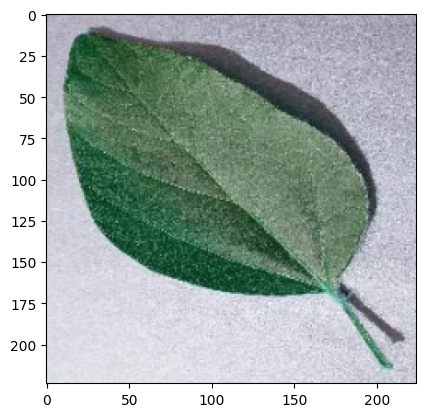

<Figure size 640x480 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))

    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()


**Confusion Matrix and Classification Report**

2/2 [==============================] - 3s 2s/step
Confusion Matrix:
[[  95    0    3 ...    0    0    0]
 [   0  117    0 ...    0    0    0]
 [   0    0   51 ...    0    0    0]
 ...
 [   0    0    0 ... 1048    0    0]
 [   0    0    0 ...    7   41    0]
 [   0    0    0 ...    0    0  268]]


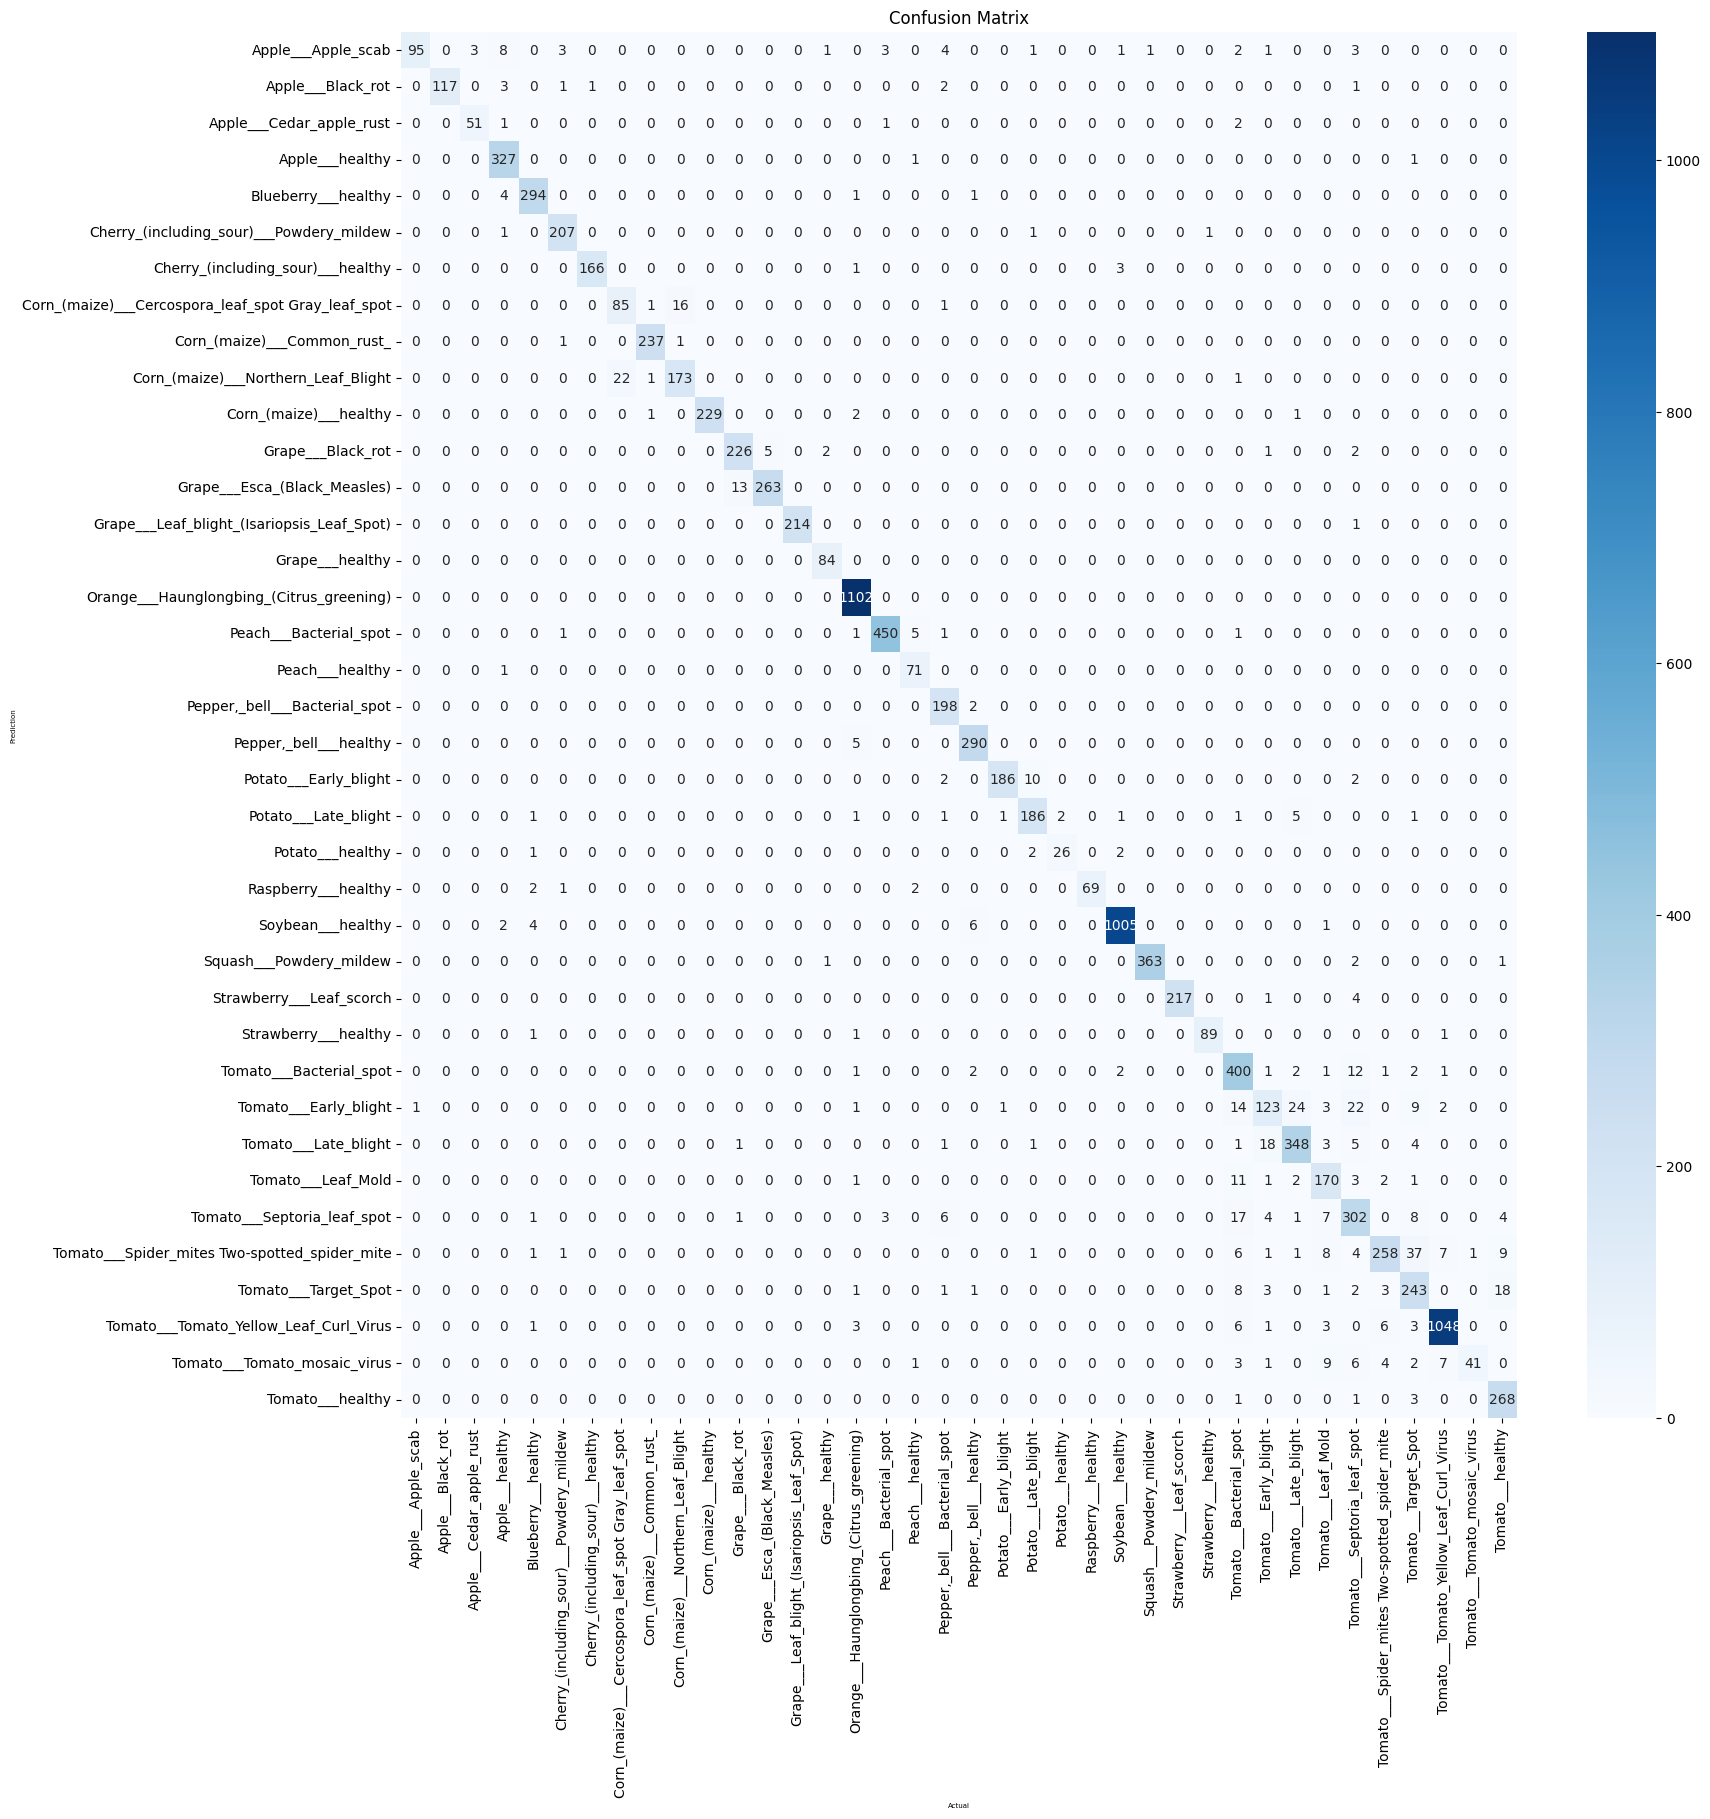


Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.75      0.86       126
                                 Apple___Black_rot       1.00      0.94      0.97       125
                          Apple___Cedar_apple_rust       0.94      0.93      0.94        55
                                   Apple___healthy       0.94      0.99      0.97       329
                               Blueberry___healthy       0.96      0.98      0.97       300
          Cherry_(including_sour)___Powdery_mildew       0.96      0.99      0.97       210
                 Cherry_(including_sour)___healthy       0.99      0.98      0.99       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.79      0.83      0.81       103
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       239
               Corn_(maize)___Northern_Leaf_Blight     

In [ ]:
# Function to get predictions for all validation data
def get_predictions(generator, model):
    predictions = []
    true_labels = []

    # Loop through batches of validation data
    for i in range(generator.samples // generator.batch_size):
        x, y_true = generator.next()

        # Get model predictions
        y_pred = model.predict(x)

        # Append true labels and predictions
        true_labels.extend(np.argmax(y_true, axis=1))
        predictions.extend(np.argmax(y_pred, axis=1))

    return np.array(true_labels), np.array(predictions)

# Get true labels and predictions
true_labels, predictions = get_predictions(validation_generator, model)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names, normalize=False):
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(18, 18))
    sns.heatmap(conf_matrix, annot=True, fmt="g" if normalize else "d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Normalized Confusion Matrix" if normalize else "Confusion Matrix")
    plt.ylabel('Prediction',fontsize=5)
    plt.xlabel('Actual',fontsize=5)

    plt.show()

#confusion matrix
plot_confusion_matrix(cm, classes)

# Compute classification report
class_report = classification_report(true_labels, predictions, target_names=classes)

# Print classification report
print("\nClassification Report:")
print(class_report)


**Export as saved model and convert to TFLite**

Now that you've trained the model, export it as a saved model

In [ ]:
t = time.time()
print(tf.__version__)
export_path = "/tmp/saved_models/{}".format(int(t))
#tf.saved_model.save(model, export_path)
tf.keras.models.save_model(model, export_path)
export_path

2.15.0


'/tmp/saved_models/1715937319'

In [ ]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer': hub.KerasLayer})


In [ ]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)

    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Tomato___Bacterial_spot, file: Tomato___Bacterial_spot/86561a43-33f2-4e52-bd0f-a6ed767feef6___GCREC_Bact.Sp 6255.JPG
1/1 [==============================] - 1s 605ms/step
PREDICTED: class: Tomato___Bacterial_spot, confidence: 0.974529


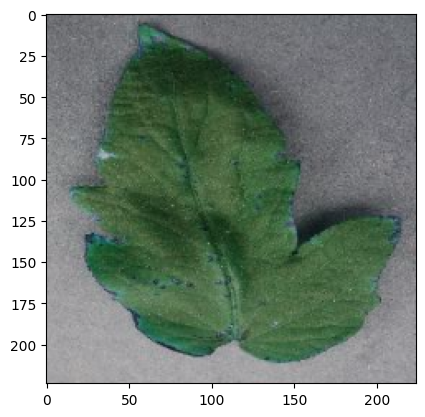

<Figure size 640x480 with 0 Axes>

SOURCE: class: Tomato___Bacterial_spot, file: Tomato___Bacterial_spot/28d82205-33bc-4119-b028-e97858fe3bc7___UF.GRC_BS_Lab Leaf 1119.JPG
1/1 [==============================] - 0s 53ms/step
PREDICTED: class: Tomato___Bacterial_spot, confidence: 0.723330


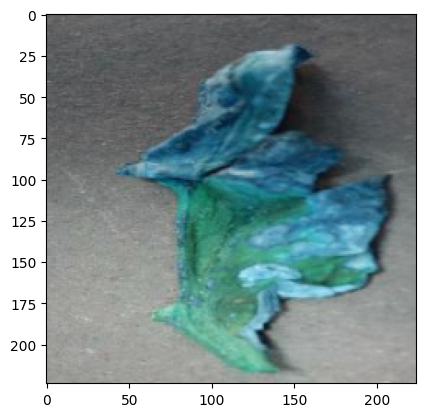

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))

    img = load_image(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

**Convert Model to TFLite**

In [ ]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/plant_disease_model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

11616692